This notebook was a first go at visualizing NBA performance grouped by race

In [2]:
import pandas as pd
import difflib
from fuzzywuzzy import process as fuzzy_process
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Download performance data from Basketball Reference

In [1]:
def download_yearly_stats(start_year = 2016, end_year = 2018):
    ''' Download NBA stats from all years in the range from Basketball Reference
        returns: list of pandas dataframes with stats, including columns for name and year
    '''
    df_list = []
    base_url = 'https://www.basketball-reference.com/leagues/NBA_{}_advanced.html'
    for year in range(start_year, end_year+1):
        print('Downloading stats for year: {}'.format(year))
        cur_year_df = pd.read_html(base_url.format(year))[0]
        cur_year_df['year'] = year
        df_list.append(cur_year_df)
    return df_list

In [16]:
%%time
all_years = download_yearly_stats(1950)

Wall time: 5min 58s


In [17]:
nba_stats_df = pd.concat(all_years).fillna({'Age':27})
nba_stats_df = nba_stats_df.query('Player != "Player" and Age != "Age"')
nba_stats_df['Player'] = nba_stats_df['Player'].str.lower().str.strip('*')
nba_stats_df['Age'] = nba_stats_df['Age'].astype(int)
nba_stats_df['birth_year'] = nba_stats_df['year'] - nba_stats_df['Age']
nba_stats_df.shape

(25282, 31)

In [18]:
nba_stats_df[['Player', 'Pos', 'Age', 'G', 'PER', 'year', 'birth_year']].sample(3)

,Player,Pos,Age,G,PER,year,birth_year
179,demar derozan,SG,24,79,18.4,2014,1990
398,elston turner,SF,29,78,7.8,1989,1960
75,t.r. dunn,SG,28,80,10.2,1984,1956


In [19]:
def get_total_season( df):
    ''' For players who are on multiple teams in one year, get the total
    '''
    if df.shape[0]==1:
        return df
    else:
        return df.query('Tm == "TOT"')

In [20]:
nba_stats_df = nba_stats_df.groupby(['Player', 'Age', 'year'], as_index=False).apply(get_total_season)

In [21]:
nba_stats_df.shape

(20847, 31)

#### Save

In [22]:
nba_stats_df.to_csv('nba_stats_1950-2018.tsv', sep ='\t', encoding = 'utf-8')

#### Load

In [2]:
nba_stats_df = (pd.read_csv('nba_stats_1950-2017.tsv', sep ='\t')[['Player', 'Age', 'PER', 'VORP', 'year', 'estimated_birth']]
                  .dropna(subset=['PER']))#.rename(columns = {'estimated_year':'birth_year'})

## Import data on race

In [13]:
def load_race_df(filename):
    race_df = (pd.read_excel(filename, errors='coerce')[['First Name', 'Middle Name', 'Last Name', 'Birthdate', 'Birth Cty', 'Ht', 'Unnamed: 15', 'Race']]
              .dropna(subset = ['First Name', 'Last Name'])
              .rename(columns = {'First Name': 'first_name',
                                 'Middle Name': 'middle_name',
                                 'Last Name': 'last_name'})
              .fillna({'Ht':'6"',  'Unnamed: 15': '0"'}))
    race_df['concat_name'] = race_df.apply(lambda row: row['first_name'] + ' ' + row['last_name'], axis = 1 ).str.lower()
    race_df['height'] = race_df.apply(lambda row: int(row['Ht'][0])* 12 + float(row['Unnamed: 15'][:-1]), axis = 1 )
    race_df['Birthdate'] = pd.to_datetime(race_df['Birthdate'], errors = 'coerce')
    race_df = race_df.dropna(subset = ['Birthdate'])
    race_df['birth_year'] = race_df['Birthdate'].dt.year
    return race_df.drop(['Ht', 'Unnamed: 15'], axis = 1)
race_df1 = load_race_df('NBAData1.xls')
race_df2 = load_race_df('NBAData2.xls')
race_df = pd.concat([race_df1, race_df2])

In [64]:
race_df[['concat_name', 'Birth Cty', 'birth_year', 'Race']].sample(3)

,concat_name,Birth Cty,birth_year,Race
990,tyree davis,USA,1979,B
1780,harold uplinger,NaN,1929,W
1182,bobby edmonds,USA,1941,B


In [66]:
%%time
unique_names = nba_stats_df.Player.unique()
race_df['Player'] = race_df.concat_name.apply(lambda name: difflib.get_close_matches(name, unique_names)[:1])
race_df['Player'] = race_df['Player'].str[0]

Wall time: 6min 22s


In [69]:
race_df.groupby('Race').size()

Race
12        2
B      2448
B/O       1
O         9
W      2057
dtype: int64

In [17]:
race_df1.query ('last_name == "Adams"')

,first_name,middle_name,last_name,Birthdate,Birth Cty,Race,concat_name,height,birth_year
14,Alvan,Leigh,Adams,1954-07-19,USA,W,alvan adams,81.0,1954
15,Donald,L.,Adams,1947-11-27,USA,B,donald adams,78.0,1947
16,George,NaN,Adams,1949-05-15,USA,B,george adams,77.0,1949
17,Glenn,Reed,Adams,1917-04-04,USA,W,glenn adams,73.0,1917
18,Hassan,Olawale,Adams,1984-06-20,USA,B,hassan adams,76.0,1984
19,Howard,O'Neale,Adams,1919-01-21,USA,W,howard adams,75.0,1919
20,Jack,NaN,Adams,1934-09-27,NaN,W,jack adams,76.0,1934
21,Michael,NaN,Adams,1963-01-19,USA,B,michael adams,70.0,1963


#### Save / load

In [8]:
race_df.to_csv('race_df.tsv', sep = '\t', encoding = 'utf-8', index = None)

In [3]:
race_df = pd.read_csv('race_df.tsv', sep ='\t', encoding='utf-8')

### Download 2018 player bios from Basketball Reference

In [42]:
import string
players_url = 'https://www.basketball-reference.com/players/{}'
all_players_df = pd.concat([pd.read_html(players_url.format(letter))[0] for letter in string.ascii_lowercase.replace('x', '')])

In [44]:
players2018_df = (all_players_df.query('To >= 2018')
                                 .assign(experience = lambda row: row['To'] - row['From']))

players2018_df.head()

,Player,From,To,Pos,Ht,Wt,Birth Date,Colleges,experience
9,Alex Abrines,2017,2018,G-F,6-6,190.0,"August 1, 1993",NaN,1
14,Quincy Acy,2013,2018,F,6-7,240.0,"October 6, 1990",Baylor University,5
21,Steven Adams,2014,2018,C,7-0,255.0,"July 20, 1993",University of Pittsburgh,4
23,Bam Adebayo,2018,2018,C-F,6-10,243.0,"July 18, 1997",University of Kentucky,0
26,Arron Afflalo,2008,2018,G,6-5,210.0,"October 15, 1985","University of California, Los Angeles",10


In [45]:
players2018_df.to_csv('players2018.tsv', sep ='\t', index = False)

#### Here I had to hand enter race

## Join the two!

In [80]:
join_df = race_df.merge(nba_stats_df, on = 'Player', how = 'right')
join_df.head(2)

,Unnamed: 0,Unnamed: 0.1,first_name,middle_name,last_name,Birthdate,Birth Cty,Race,concat_name,height,birth_year,Player,Age,PER,VORP,year,estimated_birth
0,0.0,0.0,Alaa,NaN,Abdelnaby,1968-06-24,EGY,B,alaa abdelnaby,82.0,1968.0,alaa abdelnaby,22,13.1,-0.2,1991,1969
1,0.0,0.0,Alaa,NaN,Abdelnaby,1968-06-24,EGY,B,alaa abdelnaby,82.0,1968.0,alaa abdelnaby,23,13.5,-0.5,1992,1969


In [81]:
race_df.query('last_name == "Matthews"')

,Unnamed: 0,Unnamed: 0.1,first_name,middle_name,last_name,Birthdate,Birth Cty,Race,concat_name,height,birth_year,Player
2528,2528,100,Wesley,Joel,Matthews,1959-08-24,USA,B,wesley matthews,73.0,1959,wesley matthews
2529,2529,101,Wesley,NaN,Matthews,1986-10-14,USA,B,wesley matthews,77.0,1986,wesley matthews


In [82]:
join_df['birth_diff'] = np.abs(join_df['estimated_birth'] - join_df['birth_year'])
join_df = join_df.query('birth_diff <=1').dropna(subset = ['Race'])
join_df.shape

(17036, 18)

#### Save

In [83]:
join_df.to_csv('race_per_nba.tsv', sep ='\t', encoding = 'utf-8')

### Visualize

In [246]:
def plot_year(df, year):
    fig, ax =plt.subplots(1)
    sns.distplot(join_df.query('year >= {} and year < {} and Race == "W"'.format(year, year+5))['PER'].values, bins = range(0, 30, 1), hist = False, label = 'White')
    sns.distplot(join_df.query('year >= {} and year < {} and Race == "B"'.format(year, year+5))['PER'].values, bins = range(0, 30, 1), hist = False, label = 'Black')
    ax.legend()
    plt.xlim(0, 30);

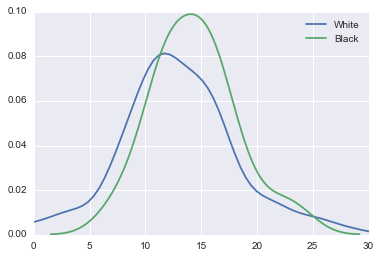

In [254]:
plot_year(join_df, 1950)

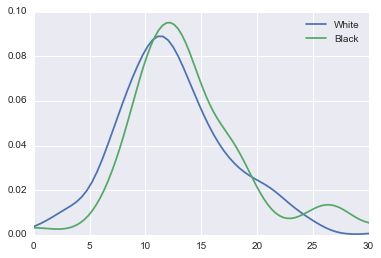

In [248]:
plot_year(join_df, 1960)

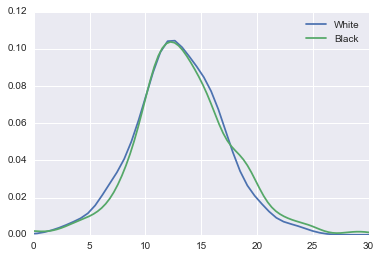

In [249]:
plot_year(join_df, 1970)

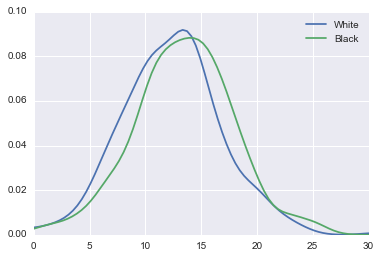

In [250]:
plot_year(join_df, 1980)

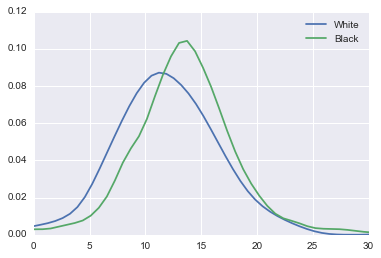

In [251]:
plot_year(join_df, 1990)

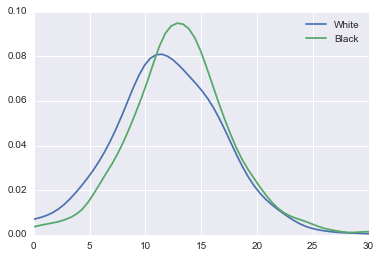

In [252]:
plot_year(join_df, 2000)

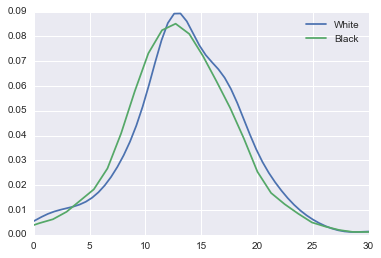

In [253]:
plot_year(join_df, 2010)